In [199]:
import pandas as pd
import numpy as np
from transformers import XLMRobertaModel, XLMRobertaTokenizer
# tokenizer = XLMRobertaTokenizer.from_pretrained('D:\\code\\bert_model\\pre_trained\\distiluse-base-multilingual-cased-v1')
# model = XLMRobertaModel.from_pretrained('D:\\code\\bert_model\\pre_trained\\distiluse-base-multilingual-cased-v1')

#model2
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer("D:\\code\\bert_model\\pre_trained\\distiluse-base-multilingual-cased-v1")

In [200]:
import os 
import torch

In [201]:
path2="D:\\code\\git-repository\\bert\\学者收集合并"
files = os.listdir(path2)

In [202]:
files

['周潇.xlsx',
 '安璐.xlsx',
 '李纲.xlsx',
 '杜健.xlsx',
 '欧阳桃花.xlsx',
 '汪雪锋.xlsx',
 '陆伟.xlsx',
 '黄翠.xlsx']

In [203]:
import pandas as pd

def extract_abstracts_to_dict(path, file):
    abstracts_dict = {}
    article_dict = {}
    for file_name in file:
        file_path = f"{path}//{file_name}"  
        df = pd.read_excel(file_path)  
        abstracts_list = []
        article_list = []
        for index,row in df.iterrows():
            try:
                if np.isnan(row['Abstract']):
                    continue
            except:
                abstracts_list.append(row['Abstract'])
                article_list.append(row['Article Title'])
            abstracts_dict[file_name.rsplit('.', 1)[0]] = abstracts_list 
            article_dict[file_name.rsplit('.', 1)[0]] = article_list

    return article_dict,abstracts_dict


article_dict,abstracts_dict = extract_abstracts_to_dict(path2, files)
article_list = []
abstracts_list = []
for item in article_dict.values():
    article_list.extend(item)

for item in abstracts_dict.values():
    abstracts_list.extend(item)


In [204]:
abstracts_zhouxiao = abstracts_dict.get('周潇', [])
article_zhouxiao = article_dict.get('周潇', [])
print(f"'周潇'的abstract列表: {abstracts_zhouxiao[:3]}") 
print(f"'周潇'的article列表: {article_zhouxiao}") 

'周潇'的abstract列表: ['Public health emergencies trigger series of chain reactions that have devastating impacts on society. In addition, the subsequent events and actors in public health emergencies represent comprehensive emergency scenarios. Taking this information into account, predicting subsequent events and actors could motivate governments to take necessary and effective countermeasures. Therefore, we develop a model for predicting subsequent events and potential actors, i.e., a subsequent multievent graph convolutional network (SMEGCN), by utilizing the evolutionary information of events. Specifically, we take both relational information and semantic information into consideration to achieve improved prediction performance and simultaneously predict subsequent actors in a convenient manner. Specifically, we collect data from the Sina microblog concerning the COVID-19 pandemic to form five news datasets by employing a Python-based agent to practically test the performance of our mo

数据清洗，去掉【结果】等没用处的字段，并去掉空值

In [116]:
# import re
# import re
# pattern = r"\[.*?\]|【.*?】"
# cleaned_abstracts_dict = {}
# for key, abstracts in abstracts_dict.items():
#     cleaned_abstracts = [re.sub(pattern, "", abstract) for abstract in abstracts if isinstance(abstract, str) and abstract]
#     cleaned_abstracts_dict[key] = cleaned_abstracts

pass
pass
fail
pass
pass
fail
fail
pass


In [191]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def text_to_embedding(text):
    try:
        inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True, add_special_tokens=True)
        inputs = {k: v.to(device) for k, v in inputs.items()} 
        with torch.no_grad():  
            outputs = model(**inputs)
        embeddings = outputs.last_hidden_state[:, 1:-1, :].cpu() 
        return embeddings
    except:
        print(text)

embedded_abstracts_dict = {}

# for key, texts in cleaned_abstracts_dict.items():
#     embedded_texts = [text_to_embedding(text) for text in texts]
#     embedded_abstracts_dict[key] = embedded_texts

for key, texts in abstracts_dict.items():
    embedded_texts = [text_to_embedding(text) for text in texts]
    embedded_abstracts_dict[key] = embedded_texts


In [215]:
#model2
embedded_abstracts_dict = {}
for key, texts in abstracts_dict.items():
    embedded_texts = []
    for text in texts:
        embedding = model.encode(text)
        embedded_texts.append(embedding)
    embedded_abstracts_dict[key] = embedded_texts
    

In [214]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

In [221]:
embedded_abstracts_dict['周潇'][2].shape

(512,)

In [193]:
import numpy as np
from sklearn.manifold import TSNE

all_embeddings = []
labels = []
for label, tensors in embedded_abstracts_dict.items():
    for tensor in tensors:
        mean_embedding = tensor.mean(dim=1).squeeze(0).numpy()
        all_embeddings.append(mean_embedding)
        labels.append(label)
embeddings_array = np.array(all_embeddings)

In [222]:
#model 2
import numpy as np
from sklearn.manifold import TSNE
all_embeddings = []
labels = []
for label, tensors in embedded_abstracts_dict.items():
    for tensor in tensors:
        all_embeddings.append(tensor)
        labels.append(label)
embeddings_array = np.array(all_embeddings)

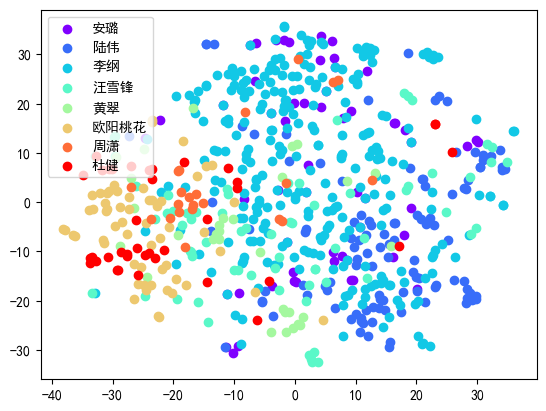

In [229]:
tsne = TSNE(n_components=2, random_state=100,perplexity=30,init='pca')
reduced_embeddings = tsne.fit_transform(embeddings_array)

unique_labels = set(labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
label_to_color = {label: color for label, color in zip(unique_labels, colors)}

for label in unique_labels:
    indices = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(reduced_embeddings[indices, 0], reduced_embeddings[indices, 1], label=label, color=label_to_color[label])

plt.legend()
plt.show()

## 可以看到，效果很差，几乎等于没做，大家的研究方向虽然相似，但是整篇段落摘要进行嵌入，粒度太粗，所以还是打算基于关键主题和词topic来做

# Kmeans聚类

d:\software\miniconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
d:\software\miniconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
d:\software\miniconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
d:\software\miniconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, 

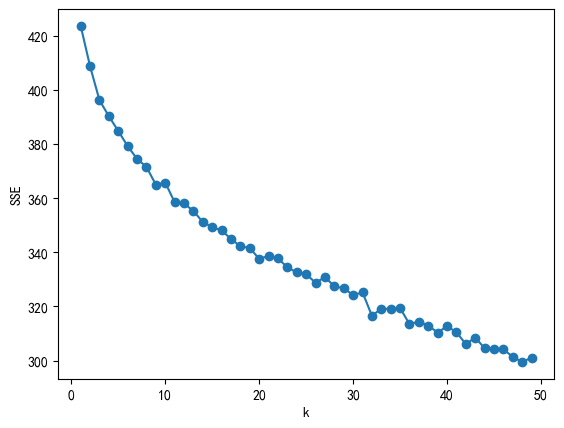

In [236]:
from sklearn.cluster import KMeans
SSE = []  # 存放每次结果的误差平方和
for k in range(1,50):
    estimator = KMeans(n_clusters=k)  # 构造聚类器
    estimator.fit(embeddings_array)
    SSE.append(estimator.inertia_)
X = range(1,50)
plt.xlabel('k')
plt.ylabel('SSE')
plt.plot(X,SSE,'o-')
plt.show()

d:\software\miniconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
d:\software\miniconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
d:\software\miniconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
d:\software\miniconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, 

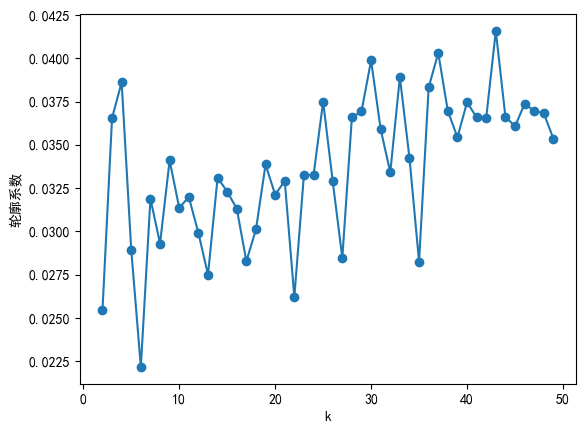

In [238]:
from sklearn.metrics import silhouette_score
Scores = []  # 存放轮廓系数
for k in range(2,50):
    estimator = KMeans(n_clusters=k)  # 构造聚类器
    estimator.fit(embeddings_array)
    Scores.append(silhouette_score(embeddings_array,estimator.labels_,metric='euclidean'))
X = range(2,50)
plt.xlabel('k')
plt.ylabel('轮廓系数')
plt.plot(X,Scores,'o-')
plt.show()

### 由图可见最佳聚类就是2类，至少在该模型的结果下
### 接下来就需要研究该模型的分类效果是否正常，即查看在该分类下，两类论文是否呈现明显不同的主题

In [197]:
cluster_num = 2

estimator = KMeans(n_clusters=cluster_num,random_state=0)
estimator.fit(embeddings_array)
clusers = []
for i in range(cluster_num):
    clusers.append([])

for index in range(len(estimator.labels_)):
    clusers[estimator.labels_[index]].append(article_list[index])

n = 1
for articles in clusers:
    df = pd.DataFrame(articles, columns=['articles'])
    df.to_excel(f"article_class_{n}.xlsx", index=False)
    n += 1

d:\software\miniconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


## 使用sci-bert和Key-bart方法 (不同于bert 使用了编码器-解码器结构，bert只使用编码器，更适合于txt2txt的文本生成，抽取论文主题）

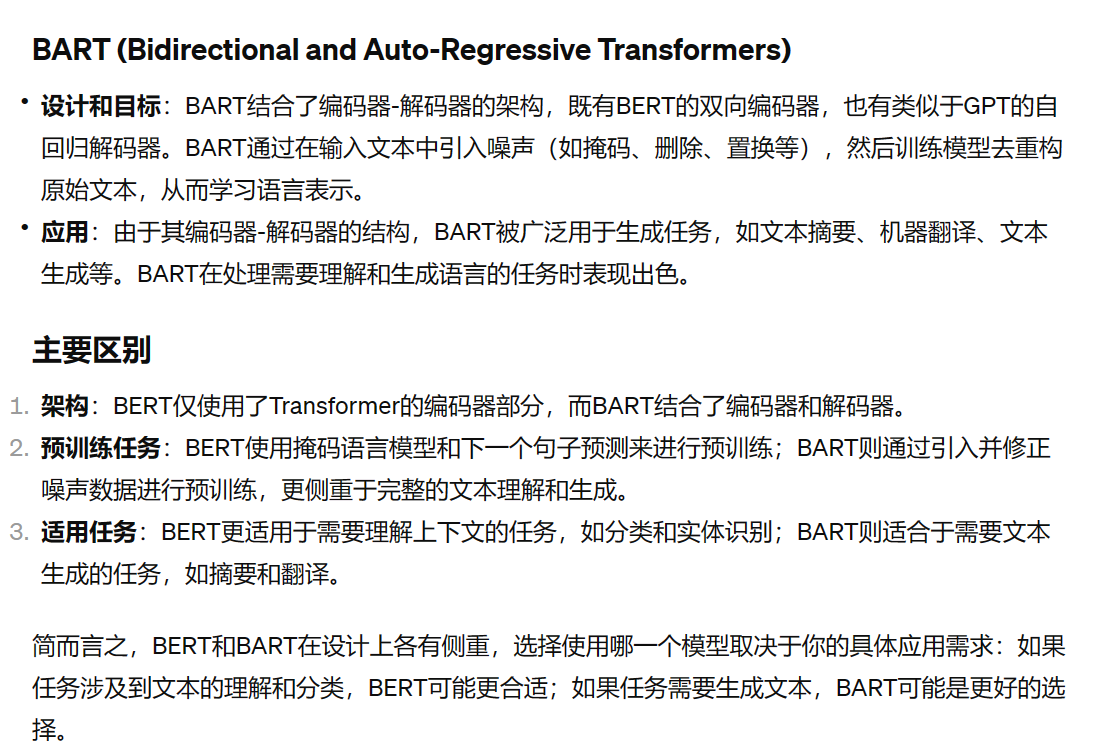

In [5]:
from IPython.display import Image
Image(filename=r"A:\新下载\1712840133188.png",width=1000,height=1000)

In [3]:
from transformers import AutoTokenizer, AutoModel
from keybert import KeyBERT
from sklearn.feature_extraction.text import CountVectorizer
tokenizer = AutoTokenizer.from_pretrained('C:\\Users\\54758\\bert\\sic-bert')
model = AutoModel.from_pretrained('C:\\Users\\54758\\bert\\sic-bert')

Some weights of the model checkpoint at C:\Users\54758\bert\sic-bert were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

In [23]:
tokenizer = AutoTokenizer.from_pretrained("C:\\Users\\54758\\bert\\keybart")
model = AutoModelForSeq2SeqLM.from_pretrained("C:\\Users\\54758\\bert\\keybart")
# 数据
data=cleaned_abstracts_dict

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(50265, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50265, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0): BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): LayerNorm((102

In [29]:
def extract_keywords(text, tokenizer, model, device):
    inputs = tokenizer.encode("extract keywords: " + text, return_tensors="pt", max_length=512, truncation=True)
    inputs = inputs.to(device)
    outputs = model.generate(inputs, max_length=50, num_beams=5, early_stopping=True)
    outputs = outputs.to('cpu')
    keywords = tokenizer.decode(outputs[0], skip_special_tokens=True)
    keywords_list = keywords.split(',')
    return keywords_list
for scholar, papers in data.items():
    print(f"学者：{scholar}")
    for paper in papers:
        keywords = extract_keywords(paper, tokenizer, model,device)
        print(f"论文关键词：{keywords}")

学者：周潇
论文关键词：['multievent graph convolutional network;public health emergencies trigger series of chain reactions that have devastating impacts on society. keywords: public health emergencies;agile principle;sequence of events and actors;social media;comparative analysis;']
论文关键词：['cognitive load theory;time series regression;data mining;false advertising;social media;data analytics;information diffusion;emotional contagion;online communications paradigm;data analysis;social networking (online);social media platform;information dissemination;']
论文关键词：['susceptible-infectious-recovered (s-i-r) dynamic model;online public opinion diffusion process;social media platform;rumor management;spreading probability and weight of intervening acts (omega(2=']
论文关键词：['subject action object;machine learning;technological innovation pathway;emerging technology;sentiment analysis;dye sensitized solar cell;expert judgment;gold nanoparticle;bibliometrics;automated learning;technical intelligence;']
论文关键词

论文关键词：['extract keywords: 突发事件情境下;japanese language;english language;chinese language;phonetics;english-chinese dictionary;english dictionary;language learning']
论文关键词：['extract keywords: 《唐宫夜宴》《只此青绿》等节目的出圈将国']
论文关键词：['logistics;extract keywords: 专利数据中包含大量的前沿技术信息，企业']
论文关键词：['extract keywords: 社交媒体关键用户识别有助于构建健康舆情']
论文关键词：['extract keywords: SHapley Additive exPlanations (shapley additive explanations);growth;extracts keywords: shapley-additive-explanations (SHapley adeplanations)']
论文关键词：['linked Open data Enabled bibliographical data (lODE-BD 3.0);bibliographic data;linked open data;bibliometrics;data mining;data analysis;data integrity;data models;data model;']
论文关键词：['extract keywords: 网络舆情是群体智慧的涌现形式之一，并对各']
论文关键词：['extract keywords: 中国情报学诞生于20世纪50年代;在发展过程中通过']
论文关键词：['extract keywords: 在公共危机事件频发的背景下;如何有效利用数�']
论文关键词：['extract keywords: 文章旨在融合知识图谱表示学习和词汇表;']
论文关键词：['word2vec;extract keywords: 突发事件的发展演化可能引发一系列次生衍']
论文关键词：['extract keywords: 构建用户特征指标体系;对恐怖事件情境下�']
论文关键词：['extract keyw

论文关键词：['knowledge integration;natural language processing;deep learning model;interdisciplinary research;co-occurrence network;biddingirectional Encoder Representation from Transformers (BERt) model;integrated knowledge phrase (IKp) identification and classification']
论文关键词：['gold standard;citation analysis;open data;bibliographic database;open system;data source;open systems;bioinformatics;biomedical research;indexation;data mining;open source software;data analysis methods;']
论文关键词：['vector concatenate fusion;logistic regression classifier;scientific citation recommendation;text representation;feature fusion;heterogenous network representation learning;link prediction;data mining;data acquisition;text analysis;citation analysis;feature extraction;text']
论文关键词：['matching-aggregation framework;multi-perspective pooling;text matching model;interaction module;interactive text matching (DITm) model;co-attention layer;encoder layer;fusion layer;co']
论文关键词：['interdisciplinarity;citation ana

论文关键词：['information retrieval;semantic annotation;language model;concept model;information retrieval model;query likelihood model;case analysis;conceptual representation;medical subject headings;relevance model;extract keywords: Manually assigned subject terms;']
论文关键词：['unsupervised artificial neural network;scientific research and technical innovation;self-organizing map (som);research institution;compound component plane (ccp) display;clustering analysis;artificial neural network (ann) display']
论文关键词：['semantic-based co-word analysis;expert knowledge integration;human intelligence network research filed;co-word index analysis;cis for short;competitive intelligence system(cIS for short) construction and visualization of human intelligence network;']
论文关键词：['extract keywords: 基于动态知识流动特征对有向的技术融合关系']
论文关键词：['extract keywords: 正0 引言科学技术是人类的创造性活动成果�']
论文关键词：['extract keywords:   探索集成不同语料库的方式    lcw-2021   cw-2018  mse ']
论文关键词：['extract keywords: 生成式技术驱动型信息生态系统以生;优势与']
论文关键词：['extract ke

论文关键词：['extract keywords: 为探究科研合作知识网络的生成机制和演�']
论文关键词：['extract keywords: 科研社交网络一样存在信息过载问题;research Gate;ac']
论文关键词：['extract keywords: 为揭示我国科研团队中学术带头人的合作状态;']
论文关键词：['extract keywords: 情报在城市突发事件应急决策中发挥着重要']
论文关键词：['extract keywords: 快速响应情报服务体系是现阶段情_��学研�']
论文关键词：['extract keywords: 城市突发事件应急响应始终伴随着信息的流�']
论文关键词：['extract keywords: 为准确识别研究内容相似但使用不同关键词的作者']
论文关键词：['extract keywords: 合作网络中心性指标-��来越多地被应用于科']
论文关键词：['extract keywords: 探索了影响因素有助于舆情预警及增强政']
论文关键词：['extract keywords: 文章系统考察了应急决策情;传递方式等明显不']
论文关键词：['extract keywords: 基于既有应急参考咨询团队构建模式研究']
论文关键词：['extract keywords: 情报服务是新型智库建设整体框架中的重要�']
论文关键词：['extract keywords: 智库情报服务是重要一环;重视智_库协向化情_']
论文关键词：['extract keywords: 针对共词分析方法中存在的共现词对同量不同质�']
论文关键词：['extract keywords: 我国中小企业信息化环境正在急剧变化;包括�']
论文关键词：['metaFilter;extract keywords: 为充分利用社交网络资源;post title;favorite及category数据']
论文关键词：['extract keywords: 信息致灾事件已成为网络环境下最为重要']
论文关键词：['extract keywords: 本文运用社会网络分析方法对浙江省某科�']
论文关键词：['extract keywords: 本文通过构建多水平;对区域人才素质的影响;']
论文关键词：['extract keyw

论文关键词：['extract keywords: 对于融入全球制造网络;企业利用外部信息的�']
论文关键词：['extract keywords: 从全球制造网络的视角系统构建了旗舰企']
论文关键词：['software as a service;extract keywords: 本文以新兴在线软件服务(saaS)作为研究�']
论文关键词：['extract keywords: 基于知识的动态能力、网络嵌入性以及创新绩']
论文关键词：['extract keywords: 绿色制造日益受到各国政府、企业及学术界的关�']
论文关键词：['extract keywords: 本文选取37个工业行为对象;通过对1998-2003年;fdi流入�']
论文关键词：['extract keywords: 本文基于企业资源观的理论核心要义;对该概']
论文关键词：['extract keywords: 技术获取模式是企业;对企;重要组分;japanese literature review;chinese']
论文关键词：['extract keywords: 以中国37个工业行为对象、采用面板数据的研究']
论文关键词：['foreign direct investment;extract keywords: 基于经济;fdi(Foreign direct investment)对我国\\�背景以及外商']
论文关键词：['extract keywords: 中印两国经济快速增长的背后有着不同的发展�']
论文关键词：['extract keywords: 作为经济细胞的企业如何快速地通过创新而成长']
论文关键词：['extract keywords: 本文主要从fDI;fdi. keywords: fdi;japanese direct investment in foreign countries;fDI in foreign direct investment;fiscal policy;economic policy;']
论文关键词：['extract keywords: 在经济全球化浪潮的推动下;作为其  "比较优�']
论文关键词：['extract keywords: 短短20年间;中国的行业收入分配迅速从平均主�']
论文关键词：['extr

论文关键词：['resource allocation;experimental evidence;power allocation;ethics power allocation mechanism;power seeking mechanism;ethical behavior diffusion;resource allocation inequity;power-seeking mechanism;in-organization resource division;power acquisition mechanism;experiment design']
论文关键词：['synthetic biology;knowledge management;knowledge structure;knowledge discovery;scientific research;knowledge based systems;technology opportunity analysis;policy maker;scientific knowledge;knowledge engineering;scientific literature;knowledge innovation;knowledge representation;knowledge visualization;knowledge base']
论文关键词：['3d printing;technology opportunity analysis (toa);technology-business relevancy network;document-keyword matrix;technology innovation and R&d strategy of enterprises;patent and trademark data matching;common product keywords extraction;technology']
论文关键词：['neural network;convolutional neural network;word embedding;molecular biology;text mining;citation analysis;text analysis

论文关键词：['subject action object;information system;two dimensions;information support system;dye sensitized solar cell;competitive environment;technological innovation;matrix decomposition;mathematical morphology;semantic relationship;subject-action-object;']
论文关键词：['solar cells;research and development;correlation mapping;subject action object;data visualisation;semantic analysis;topic term;data mining;information retrieval;knowledge management;knowledge based systems;information analysis and retrieval  problem and solution']
论文关键词：['extract keywords: a Subject-action-object (sao);bibliometrics;parse tree-based hierarchical SAo extraction model;a Subject-Action-object structure;co-word analysis (caw) and co-']
论文关键词：['information technology;hot spot;big data;innovation pathway;natural science;information technology research;national science foundation;national natural science foundation of china;research hot-spots;data mining;data processing;data management;data']
论文关键词：['subject-action

论文关键词：['deep learning;cultural heritage;cultural concern;cultural unit;cultural focus;cultural study;image analysis;image collection;automatic analysis;cultural research;image dataset;cultural studies;image processing;image retrieval;image classification;image preservation;']
论文关键词：['covariance matrix;fast fourier transform;image denoising;doppler effect;fourier transforms;mean-based geometric detector;divergence mean-based detector;image resolution;image processing;cov']
论文关键词：['citation network;power law distribution;exponential distribution;citation analysis;computer science publication record;citing relationship;extract keywords: citing cascade;cited paper;cite count;advanced property;citations depth;']
论文关键词：['data mining;extract keywords: frequent subgraph mining;mapreduce;isomorphism test. keywords: breadth-first search strategy;frequent subgraphs mining;data mining application;centralized system;graph data mining;']
论文关键词：['finite element method;support vector machine;relative 

论文关键词：['search engine;distance education;distance medical treatment;digital library;distance marketing;distance government;distance commerce;e commerce;internet management;e-government;distance medicine treatment;search engines;distance communication;distance network;distance computing;']
论文关键词：['open systems;open system;computer science;computer networks;computer architecture;computer network;computer languages;information technology;information science education;information retrieval;data mining;information analysis;information theory;information systems;information processing;information system']
论文关键词：['extract keywords: 随着数据要素成为国家战略性资源;数_��分']
论文关键词：['human factors;ergonomics;occupational safety;suicide prevention;injury prevention;extract keywords: "人智交互"和"人本人工"能" ']
论文关键词：['association for Computing Machinery;computer science;extract keywords: 为进一步挖掘学术-��文新颖性的丰�']
论文关键词：['extract keywords: 立足专利;extracting keywords: keywords: extract keywords: extract keywords;extraction keywords

## 这个模型似乎并不能很好处理中文，中文得想办法使用其他方法，先搞英文

In [35]:
def contains_chinese(text):
    return any('\u4e00' <= char <= '\u9fff' for char in text)# 检查文本是否包含中文字符
def extract_keywords2(text, tokenizer, model, device):
    if contains_chinese(text):
        return []#去除中文部分
    inputs = tokenizer.encode("extract keywords: " + text, return_tensors="pt", max_length=512, truncation=True).to(device)
    outputs = model.generate(inputs, max_length=50, num_beams=5, early_stopping=True).to('cpu')
    keywords = tokenizer.decode(outputs[0], skip_special_tokens=True).split(',')
    return keywords

scholars_keywords = {}

In [36]:
from collections import Counter
for scholar, papers in data.items():
    all_keywords = []
    for paper in papers:
        keywords = extract_keywords2(paper, tokenizer, model, device)
        all_keywords.extend(keywords) 
    scholars_keywords[scholar] = all_keywords

In [38]:
# for scholar, keywords in scholars_keywords.items():
#     keyword_counts = Counter(keywords)
#     sorted_keywords = sorted(keyword_counts.items(), key=lambda x: x[1], reverse=True)
#     print(f"学者：{scholar}")
#     for keyword, freq in sorted_keywords:
#         print(f"{keyword}: {freq}")
#     print("\n")

In [43]:
for scholar, keywords in scholars_keywords.items():
    all_keywords = [keyword for i in keywords for keyword in i.split(';') if keyword]  # 分割每个字符串，忽略空字符串
    keyword_counts = Counter(all_keywords)
    sorted_keywords = sorted(keyword_counts.items(), key=lambda x: x[1], reverse=True)
    print(f"学者：{scholar}")
    for keyword, freq in sorted_keywords:
        print(f"{keyword}: {freq}")
    print("\n")

学者：周潇
dye sensitized solar cell: 4
emerging technology: 3
bibliometrics: 3
text mining: 3
technology roadmapping: 3
social media: 2
social media platform: 2
machine learning: 2
empirical study: 2
nano-enabled drug delivery: 2
innovation pathway: 2
text analysis: 2
multievent graph convolutional network: 1
public health emergencies trigger series of chain reactions that have devastating impacts on society. keywords: public health emergencies: 1
agile principle: 1
sequence of events and actors: 1
comparative analysis: 1
cognitive load theory: 1
time series regression: 1
data mining: 1
false advertising: 1
data analytics: 1
information diffusion: 1
emotional contagion: 1
online communications paradigm: 1
data analysis: 1
social networking (online): 1
information dissemination: 1
susceptible-infectious-recovered (s-i-r) dynamic model: 1
online public opinion diffusion process: 1
rumor management: 1
spreading probability and weight of intervening acts (omega(2=: 1
subject action object: 1
t

### 虽然都提取出来了，但每个的词频似乎都不太高，拿来聚类效果一般不明显